In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Sat Jan 20 18:08:26 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   27C    P0    42W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.randn_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = -8
hp.const_sigma = True
hp.quantize = True

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [8]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-10/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0
-rw-rw-r-- 1 scpark scpark 0  1월 20 18:08 events.out.tfevents.1705741722.GPUSVR11


### Dataset

In [9]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
print('done')

done


In [10]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [11]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [12]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

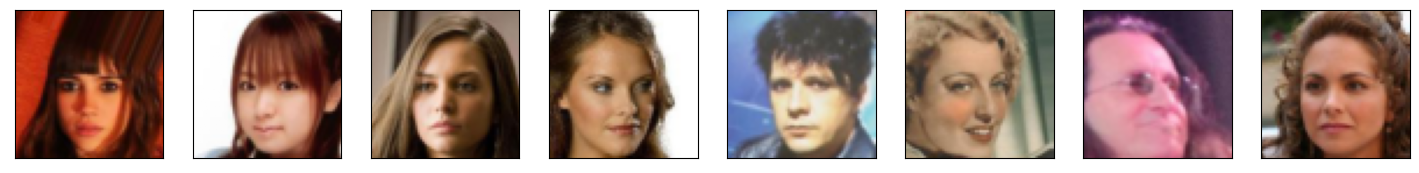

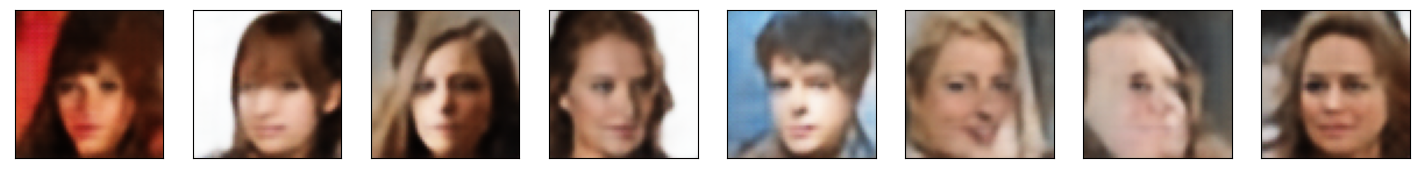

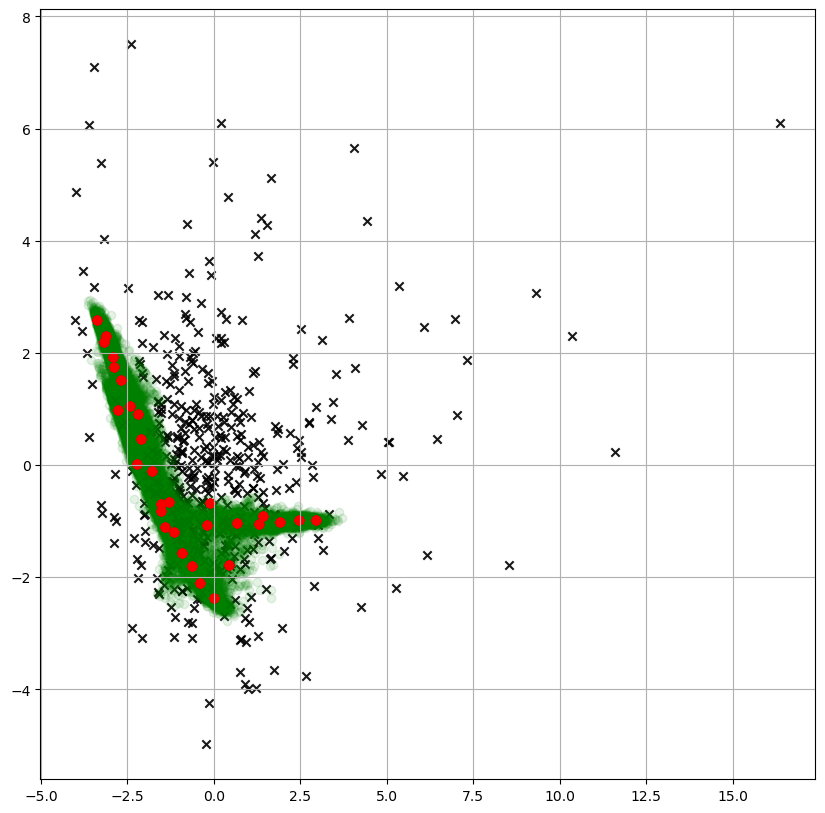

11001
lse_loss 225737744.0
commit_loss 0.0025114265736192465
recon_loss 0.003730055410414934
11002
lse_loss 225221312.0
commit_loss 0.0028493967838585377
recon_loss 0.0040997108444571495
11003
lse_loss 225690960.0
commit_loss 0.0025760186836123466
recon_loss 0.003675198880955577
11004
lse_loss 225601136.0
commit_loss 0.0027922107838094234
recon_loss 0.00380707043223083
11005
lse_loss 225684688.0
commit_loss 0.0028031666297465563
recon_loss 0.004227188415825367
11006
lse_loss 225584464.0
commit_loss 0.0027209792751818895
recon_loss 0.003819948062300682
11007
lse_loss 225344128.0
commit_loss 0.0028919184114784002
recon_loss 0.004073516000062227
11008
lse_loss 226005616.0
commit_loss 0.0026291452813893557
recon_loss 0.0036539610009640455
11009
lse_loss 225909040.0
commit_loss 0.003026294056326151
recon_loss 0.003978499211370945
11010
lse_loss 226209760.0
commit_loss 0.002760701347142458
recon_loss 0.0037321883719414473
11011
lse_loss 226324144.0
commit_loss 0.0026182925794273615
recon_los

In [ ]:
from IPython import display

min_indices = set()
while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            quant_temp = linear(1, 0, step, 0, 5*1000)
            data = model(data, quant_temp=0, latent_temp=1)
            min_indices.update(list(data['min_indices'].data.cpu().numpy()))

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            ze_pca = pca.transform(data['ze'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            zq_pca = pca.transform(data['zq'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=0.9, color='black')
            plt.scatter(ze_pca[:, 0], ze_pca[:, 1], marker='o', alpha=0.1, color='green')
            plt.scatter(zq_pca[:, 0], zq_pca[:, 1], marker='o', alpha=0.1, color='red')
            plt.grid()
            plt.show() 
            
            usage = len(min_indices) / hp.n_prior_embeddings
            writer.add_scalar('usage', usage, step)
            min_indices = set()
    
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

data = preprocess(batch)

# Forward
model.train()
model.zero_grad()
quant_temp = linear(1, 0, step, 0, 5*1000)
data = model(data, quant_temp=quant_temp, latent_temp=1)

x = data['x']
y = data['y']

plot(x)
plot(y)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
ze_pca = pca.transform(data['ze'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
zq_pca = pca.transform(data['zq'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=0.9, color='black')
plt.scatter(ze_pca[:, 0], ze_pca[:, 1], marker='o', alpha=0.1, color='green')
plt.scatter(zq_pca[:, 0], zq_pca[:, 1], marker='o', alpha=0.1, color='red')
plt.grid()
plt.show() 

usage = len(min_indices) / hp.n_prior_embeddings
writer.add_scalar('usage', usage, step)
min_indices = set()